In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

In [2]:
# Define an RBF (Gaussian) Kernel
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    """Computes the RBF kernel matrix."""
    sq_dist = cdist(X1, X2, 'sqeuclidean')
    return sigma_f ** 2 * np.exp(-sq_dist / (2 * length_scale ** 2))

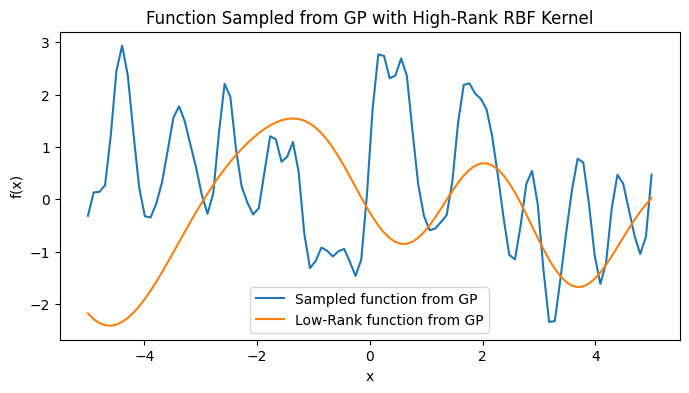

In [155]:
# Generate input points
X = np.linspace(-5, 5, 10**2).reshape(-1, 1)

# Compute kernel matrix (covariance matrix for the GP)
K = rbf_kernel(X, X, length_scale=0.2)
K_low_rank = rbf_kernel(X, X, length_scale=1)

# Sample from a Gaussian Process (mean=0, covariance=K)
f_samples = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
f_samples_low_rank = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K_low_rank)

# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples, label="Sampled function from GP")
plt.plot(X, f_samples_low_rank, label="Low-Rank function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

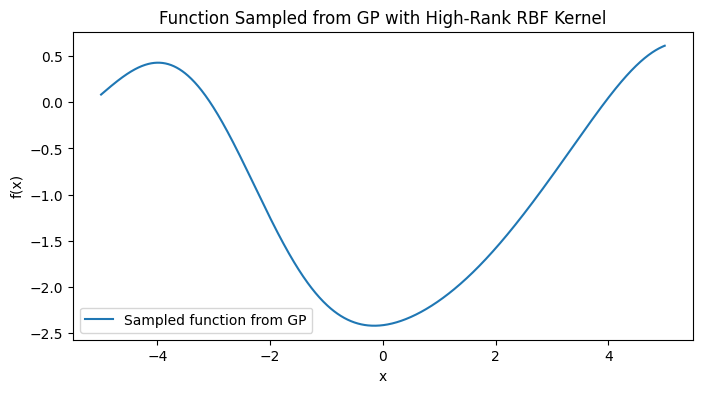

In [29]:
# Plot the sampled function
plt.figure(figsize=(8, 4))
plt.plot(X, f_samples[0,:], label="Sampled function from GP")
plt.title("Function Sampled from GP with High-Rank RBF Kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [146]:
class GPfunctions:
    def __init__(self, K, length_scale):
        self.K=K
        self.num_points= 500 #number
        self.actionspace = np.random.choice(np.linspace(-5, 5, 10**5), self.num_points, replace=False).reshape(-1, 1)
        self.length_scale=length_scale
        # Compute covariance matrix
        self.kernel = self.rbf_kernel()
        self.subset = self.algorithm()

    # RBF (Gaussian) Kernel
    def rbf_kernel(self, sigma_f=1.0):
        """Computes the RBF kernel matrix."""
        sq_dist = cdist(self.actionspace,self.actionspace, 'sqeuclidean')
        return sigma_f ** 2 * np.exp(-sq_dist / (2 * self.length_scale ** 2))
    
    def algorithm(self):
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=self.K)
        # Find the max index for each batch
        max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)
        # Get unique max indices
        subset = np.unique(max_indices)
        print("Unique actions:", subset)
        return subset
    
    def test(self):
        num_batches = 10**4  # Number of function samples for testing
        # Sample multiple functions from the GP
        f_samples = np.random.multivariate_normal(mean=np.zeros(self.num_points), cov=self.kernel, size=num_batches)
        return np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,self.subset], axis=1))

In [150]:
report=pd.DataFrame(columns=['EmpiricialRegret','length_scale','K'])

for K in [5,10]:
    for length_scale in [0.1,0.5,1.,1.5,2]:
        for ignore in range(3):
            output=GPfunctions(K,length_scale).test()
            row=pd.Series({'EmpiricialRegret':output,'length_scale':length_scale,'K':K})
            report = pd.concat([report,row.to_frame().T], ignore_index=True)

# report.to_csv('/data/report_postprocess_adult_'+str(pa)+'.csv',index=None)

Unique actions: [ 27  79 148 415 416]


C:\Users\zhouq\AppData\Local\Temp\ipykernel_2072\2483677861.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report = pd.concat([report,row.to_frame().T], ignore_index=True)


Unique actions: [ 81 121 153 180 345]
Unique actions: [132 143 227 267 349]
Unique actions: [ 61  96 276 446 470]
Unique actions: [180 331 336 438 457]
Unique actions: [ 80 154 258 345 435]
Unique actions: [ 33 114 379 441]
Unique actions: [  3 291 354 469 487]
Unique actions: [303 364 365 374 393]
Unique actions: [111 290 329 468 485]
Unique actions: [ 43 173 240 313 476]
Unique actions: [106 235 271 478 482]
Unique actions: [185 193 236 399 465]
Unique actions: [ 35  77 145 237 478]
Unique actions: [132 312 357 374 415]
Unique actions: [  2  20 131 145 175 346 347 383 415 430]
Unique actions: [ 86  95 127 233 271 368 372 375 379 458]
Unique actions: [  0   8  16  25  96 100 113 171 269 479]
Unique actions: [ 34  67 112 231 322 326 404 409 428 482]
Unique actions: [  9 158 292 335 393 407 460 465 492 497]
Unique actions: [ 70  88 145 155 302 310 313 370 390 421]
Unique actions: [ 61  84 234 255 271 403 419 451 465 487]
Unique actions: [ 10  14  45 116 178 315 361 414 465 468]
Unique a

In [152]:
report.groupby(by=["length_scale",'K']).mean()

EmpiricialRegret
length_scale K                     
0.1          5.0           1.401427
             10.0          1.030953
0.5          5.0           0.775071
             10.0          0.477270
1.0          5.0           0.555556
             10.0          0.316616
1.5          5.0           0.311565
             10.0          0.208962
2.0          5.0           0.205753
             10.0          0.125795

In [153]:
report.groupby(by=["length_scale",'K']).std()

EmpiricialRegret
length_scale K                     
0.1          5.0           0.049722
             10.0          0.017626
0.5          5.0           0.056616
             10.0          0.047867
1.0          5.0           0.265376
             10.0          0.107137
1.5          5.0           0.029193
             10.0          0.005240
2.0          5.0           0.099867
             10.0          0.042646

In [93]:
# Define parameters
num_batches = 5 # Number of function samples
num_points = 500 # Cardinality of full action space 
actionspace = np.random.choice(np.linspace(-5, 5, 10**5), num_points, replace=False)
length_scale=1

# Generate input points
X = actionspace.reshape(-1, 1)
# Compute covariance matrix
kernel = rbf_kernel(X, X, length_scale=length_scale)

def train():
    # Sample multiple functions from the GP
    f_samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=kernel, size=num_batches)

    # Find the max index for each batch
    max_indices = np.argmax(f_samples, axis=1)  # Shape: (num_batches,)

    # Get unique max indices
    subset = np.unique(max_indices)

    print("Unique actions:", subset)
    return subset

subset=train()

Unique actions: [156 236 318 469 479]


In [94]:
# Define parameters
num_batches = 10**5  # Number of function samples

# Example covariance matrix
# kernel = rbf_kernel(X, X, length_scale=length_scale)

# Sample multiple functions from the GP
f_samples = np.random.multivariate_normal(mean=np.zeros(num_points), cov=kernel, size=num_batches)

np.average(np.max(f_samples, axis=1)-np.max(f_samples[:,subset], axis=1))

0.5445082334701965

In [100]:
f_samples.shape

(5, 100)